# PyTorch Workflow

Let's explore an example PyTorch of end-to-end workflow
- Data (prepare and load)
- Build model
- Fitting the model to data (training)
- Making predictions and evaluating a model (inference)
- Saving and loading model
- Putting it all together

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural network
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'1.12.1+cu113'

## 1. Data (preparing and loading)

Data can be almost everything... in machine learning.

- Excel spreadsheet
- Images
- Videos
- Audio
- Text etc...

Machine learning is a game of two parts:
1. Get data into numerical representation
2. Build a model to learn pattern in that numerical representation.

Let's create some *known* data using the linear regression formula.

We'll use a [linear regression](https://en.wikipedia.org/wiki/Linear_regression) formular to make a straight line with known parameters.

In [ ]:
# Create a *known* parameters

weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

Beautiful! Now we're going to move towards building a model that can learn the relationship between `X` (**features**) and `y` (**labels**).

### Splitting data into training and test sets (one of the most concept in mahine learning)

This step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

### How might we better visualize our data ? -> Data Visualization

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data a,d compares predicitons.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  #Plot test data in blue
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there prediciton?
  if predictions is not None:
    # Plot the predicitons if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

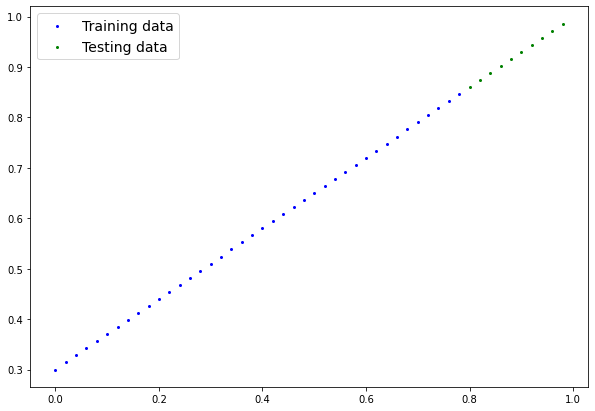

In [ ]:
plot_predictions()

## 2. Build model

Our first Pytorch model!

What our model will do:
- Start with random  values (weight and bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data).

How does it do so ?
- Gradient Descent
- Backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # -> almost evrything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    # Create two parameters and instantiate them as random values.
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # keep track of the gradient of our parameter and update them with Gradient Descent algorithm and backpropagation.
                                            dtype=torch.float32)) # pytorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1, # start with a random bias and try to adjust it to the ideal weight
                                        requires_grad=True, # keep track of the gradient of our parameter and update them with Gradient Descent algorithm and backpropagation.
                                        dtype=torch.float32)) # pytorch loves the datatype torch.float32
    
    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula


Almost every model in pytorch inherits from `nn.Module`, and we you are not going to inherit from nn.Module, we should  overrite the forward() method to define what computation is happening in the model.

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [torch.nn](https://pytorch.org/docs/stable/nn.html), [torch.optim](https://pytorch.org/docs/stable/optim.html), [torch.utils.data.Dataset](https://pytorch.org/docs/stable/optim.html) and [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

- `torch.nn` -> contains all of the buildings for computational graphs (neural networks)
- `torch.nn.Parameter` -> which parameters should our model try and learn, often A Pytorch layer from torch.nn will set these for us
- `torch.nn.Module` -> the base class for all neural network modules, if you subclass it, you should overwrite `forward()`
- `torch.optim` -> this is where optimizers in PyTorch live, they will help with gradient Descent
- `def forward()` -> All nn.Module subclasses require you to overwrite forward(), this method defines what happen in the forward computation

### Checking the contents of our PyTorch model

Now that we've created our model, let's see what inside.

So we can check our model parameters or what's inside our model using '.paremeters()'.

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (This is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

Let's see how well it predicts `y_test` based on `X_test`.
It's going to run it though `forward()` method.

In [ ]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [ ]:
# Make predictions with model
# inference_mode() turns off gradient tracking. Pytorch will keep track of less data, so your prediction will be faster.
with torch.inference_mode():
  y_preds = model_0(X_test)

# it will do the same thing but inference_mode has more options.
# with torch.no_grad():
#  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

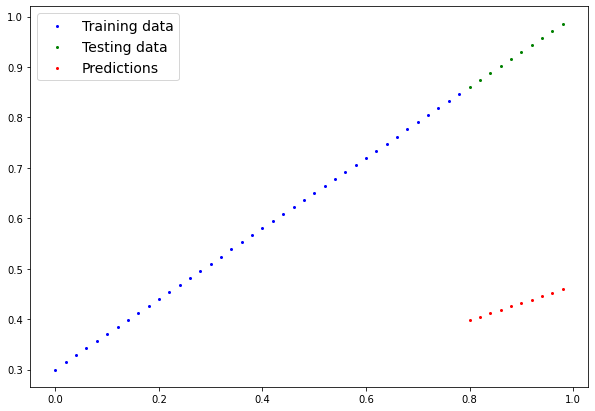

In [ ]:
# Let's visualize
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

Those predictions look pretty bad...

This make sense though when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

Time to change that.

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.
In other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong our model predictions are is to use a **loss function** (can also be called **cost function** or **criterion** in different areas).

Things we need to train:
- **Loss function:** A function to measure how wrong our model's predictions are to the ideal outputs, lower is better. PyTorch has plenty of built-in loss functions in [torch.nn](https://pytorch.org/docs/stable/nn.html#loss-functions)
- **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (weight and bias). You can use various optimization function implementations in [torch.optim](https://pytorch.org/docs/stable/optim.html)

And especially for PyTorch, we need:
- **A training loop**
- **A testing loop**

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss() # Mean Absolute Error (MAE) for regression problems

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr (learning rate): possibly the most important hyperparameter.

### Building a training loop (and testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward()' to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad. (they accumulate every epoch, zero them to start fresh each forward pass)
4. Loss Backward - move backwards through the network to calculate he gradients of each of the parameters of our model with respect to the loss. (**backward propagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss function (**gradient descent**)


In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data ...
epochs = 200

# Create empty loss lists to track different values
epoch_count = []
train_loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  ### Training

  # Set the model to training mode
  model_0.train() # train mode in PyTorch set all parameters that requires gradients to require gradients.

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our model's prediction to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # By default how the gradient changes will accumulate through the loop so..., we have to zero them above in step 3 (updagte model's parameters)
  
  ### Testing

  # Set the model to evaluation mode
  model_0.eval() # turns off (gradient tracking) different settings in the model not needed for evaluation/testing (dropout).
  
  with torch.inference_mode(): # During evaluation, we turn off the things we don't need.
    # 1. Do the forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate the loss on test data
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test loss: {test_loss}")
    # Print out model state_dict
    print(model_0.state_dict())

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE 

Looks like our loss is going down with every epoch, let's plot it to find out.

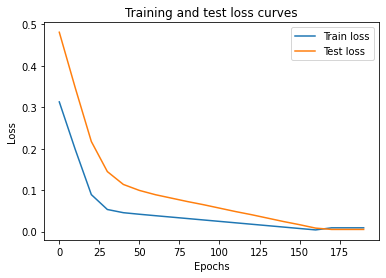

In [ ]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

The **loss curves** show the loss going down over time. Remember, loss is the measure of how wrong your model is, so the lower the better.

Let's inspect our model's [.state_dict()](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see see how close our model gets to the original values we set for weights and bias.

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Our model got very close to calculate the exact original values for `weight` and `bias` (and it would probably get even closer if we trained it for longer).

## 4. Making predictions with a trained PyTorch model (inference)

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).

2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).

3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_pred_new = model_0(X_test)

In [ ]:
print(y_pred_new)

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


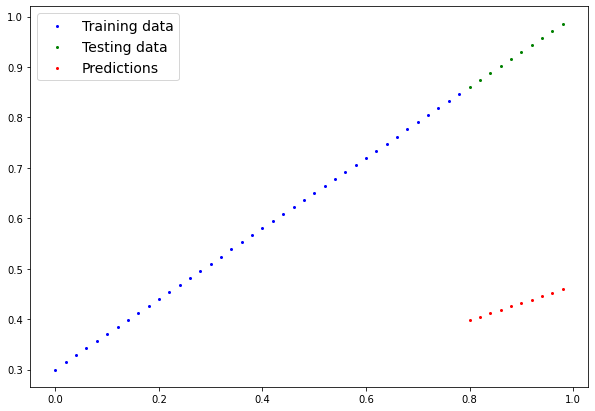

In [ ]:
# We've made some predictions with our trained model, now how do they look before training our model?
plot_predictions(predictions=y_preds)

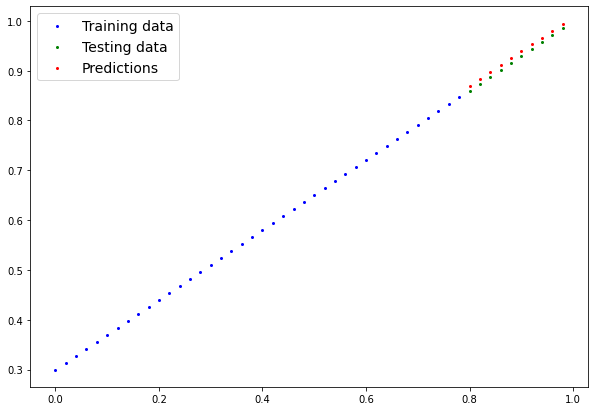

In [ ]:
# Now how do they look after training our model?
plot_predictions(predictions=y_pred_new)

Those red dots are looking far closer than they were before!

## 5. Saving and loading a Pytorch model

### Saving a Pytorch model

There are three main methods you should know about saving models in PyTorch. [link](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)


1. `torch.save()` - allows you save a PyTorch object in Python's pickle format. **(save the entire model)**
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary **(recommended way)**

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

 A **state_dict** is a python dictionary object that maps each layer to its parameter tensor.

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create a model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Nov 25 08:35 01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.state_dict() # It's initialize with random parameters

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Let's load !!!
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
## Make some predictions with our loaded model
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
y_pred_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indiates our model is saving and loading as expected.

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt 

# Check ¨PyTorch version
torch.__version__

'1.12.1+cu113'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!nvidia-smi

Fri Nov 25 08:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 6.1 Data

Let's create some data just like before.

First, we'll hard-code some `weight` and `bias` values.

Then we'll make a range of numbers between 0 and 1, these will be our `X` values.

Finally, we'll use the `X` values, as well as the `weight` and `bias` values to create `y` using the linear regression formula (`y = weight * X + bias`).

In [ ]:
# Create some data using the linear regression formula using the formula of y = weight * X + b
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features ans labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will will happen later on (shapes within linear layers)
y = weight * X + bias 

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

We've got some data, let's split it into training and test sets.

We'll use an 80/20 split with 80% training data and 20% testing data.

In [ ]:
# Split the data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

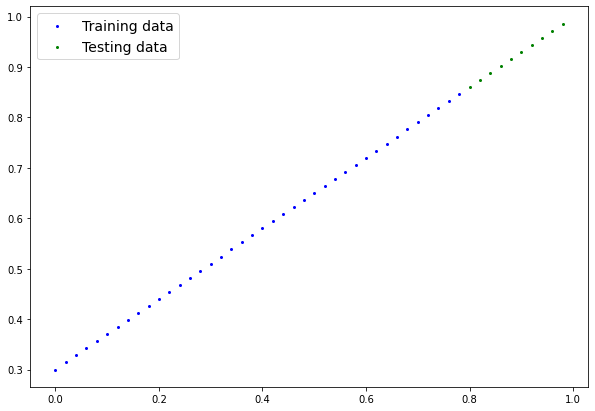

In [ ]:
# Let's visualize them to make sure they look okay.
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear model

We've got some data, now it's time to make a model.

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use [nn.Linear(in_features, out_features)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are `1` since our data has `1` input feature (`X`) per label (`y`).



In [ ]:
# Create a linear model by subclassing nn.Module
# Instead of initialize each parameter as we did before, we will inistialize layers that have the parameter in those layers.
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters.
    self.linear_layer = nn.Linear(in_features=1, # input of size 1 (one value of X)
                                  out_features=1) # output of size 1 (one value of y)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set manual seed for reproducibility
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

It looks like the model is on the CPU by default.

Let's change it to be on the GPU (if it's available).

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

Since we have access to the GPU, now our model is on the GPU.

### 6.3 training

For training we need:
- Loss function
- Optimiser
- Training Loop
- Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optmizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                                lr=0.01)

In [ ]:
# Let's write the training loop
torch.manual_seed(42)

epochs = 1000

# Put data on the target device (device agnostic code for data)
# All the data we compute must be on the same device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train() # train mode is on by default after construction

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform bakpropagation
  loss.backward()
  
  # 5. Optimizer steps
  optimizer.step()

  ### Testing
  model_1.eval() # put the model in evaluation mode for testing (inference)
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_1(X_test)
    
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 10 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 20 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 30 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 40 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 50 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 60 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 70 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 80 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 90 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 100 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 110 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 120 | Train Loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 130 | Train Loss

In [ ]:
# Find our model's learned parameters
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])


In [ ]:
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")


And the original values for weights and bias are:
weights: 0.7, bias: 0.3


We need to make some improvements (maybe we need to train longer). Our model's parameters are from the original values. 

### 6.4 Making and evaluating predictions

Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.

In [ ]:
# Turn our model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]], device='cuda:0')

If you're making predictions with data on the GPU, you might notice the output of the above has `device='cuda:0'` towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.

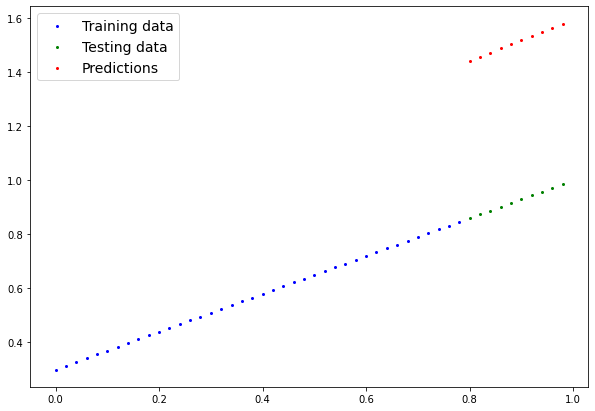

In [ ]:
# Check out our model model predictions visually
import numpy as np
plot_predictions(predictions=np.array(torch.Tensor(y_preds).cpu().numpy()))

As we already discussed, our model doesn't perform well on the test data, the predicted values (red points) are far from the ground truth values (green points).

### 6.5 Saving and loading our model

For this demo, we won't try to improve our model's performance. We will save it to a file so it can be used later.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch model

# Create a new instance of linear regression model v2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')